In [0]:
# Cell 0 - env check (no sparkContext usage)
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("CE_Fraud").getOrCreate()
print("Spark version:", spark.version)
# Show a tiny smoke test
spark.range(1,4).show()


Spark version: 4.0.0
+---+
| id|
+---+
|  1|
|  2|
|  3|
+---+



In [0]:
# Cell 1 - imports
import pandas as pd
import numpy as np
from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType, IntegerType
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import array
import os
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import BinaryClassificationEvaluator

print("Imports OK")


Imports OK


In [0]:
# Cell 2 - load via pandas then convert to spark (most reliable for CE)
url = "https://raw.githubusercontent.com/mayankyadav23/Credit-Card-Fraud-Detection/main/balanced_dataset.csv"
pdf = pd.read_csv(url)
# Drop irrelevant columns if present
pdf = pdf.drop(columns=['Time','Unnamed: 0'], errors='ignore')
print("pandas shape:", pdf.shape)
# convert to spark
df = spark.createDataFrame(pdf)
#df = df.cache()
print("spark rows:", df.count())
df.printSchema()
# show class balance
df.groupBy("Class").count().show()


pandas shape: (984, 30)
spark rows: 984
root
 |-- V1: double (nullable = true)
 |-- V2: double (nullable = true)
 |-- V3: double (nullable = true)
 |-- V4: double (nullable = true)
 |-- V5: double (nullable = true)
 |-- V6: double (nullable = true)
 |-- V7: double (nullable = true)
 |-- V8: double (nullable = true)
 |-- V9: double (nullable = true)
 |-- V10: double (nullable = true)
 |-- V11: double (nullable = true)
 |-- V12: double (nullable = true)
 |-- V13: double (nullable = true)
 |-- V14: double (nullable = true)
 |-- V15: double (nullable = true)
 |-- V16: double (nullable = true)
 |-- V17: double (nullable = true)
 |-- V18: double (nullable = true)
 |-- V19: double (nullable = true)
 |-- V20: double (nullable = true)
 |-- V21: double (nullable = true)
 |-- V22: double (nullable = true)
 |-- V23: double (nullable = true)
 |-- V24: double (nullable = true)
 |-- V25: double (nullable = true)
 |-- V26: double (nullable = true)
 |-- V27: double (nullable = true)
 |-- V28: double (n

In [0]:
# Cell 3 - cast numeric columns & label, and remove any columns that are non-numeric
label_col = "Class"
# cast all columns (except label) to double safely
for c, t in df.dtypes:
    if c != label_col:
        df = df.withColumn(c, F.col(c).cast(DoubleType()))
# cast label explicitly to integer
df = df.withColumn(label_col, F.col(label_col).cast(IntegerType()))
# drop rows with nulls (dataset is small; if many nulls consider imputation instead)
nulls = df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas().T
if nulls[0].sum() > 0:
    print("Null counts found; dropping rows with nulls")
    df = df.na.drop()
print("After cleaning rows:", df.count())


After cleaning rows: 984


In [0]:
# Cell 4 - create 3 derived features to improve signal without exploding feature set
# 1) absolute amount, 2) log1p(amount), 3) transaction magnitude (L2 norm of V1..V28)
# Adjust features present in your df if shapes differ
feature_base = [c for c in df.columns if c not in (label_col,)]
# Ensure V1..V28 exist; fallback to available numeric features
v_cols = [c for c in feature_base if c.startswith("V")]  # V1..V28 typical
print("Using V cols count:", len(v_cols))

# derived features
df = df.withColumn("Amount_abs", F.abs(F.col("Amount")))
df = df.withColumn("Amount_log1p", F.log1p(F.abs(F.col("Amount"))))

# transaction magnitude: sqrt(sum(Vi^2)) as a single scalar
sq_sum = None
for c in v_cols:
    if sq_sum is None:
        sq_sum = F.col(c) * F.col(c)
    else:
        sq_sum = sq_sum + (F.col(c) * F.col(c))
if sq_sum is None:
    # fallback: use Amount as magnitude if V cols missing
    df = df.withColumn("txn_magnitude", F.abs(F.col("Amount")))
else:
    df = df.withColumn("txn_magnitude", F.sqrt(sq_sum))

# final feature columns we'll use (keeps size moderate)
feature_cols = v_cols + ["Amount", "Amount_abs", "Amount_log1p", "txn_magnitude"]
print("Final feature columns count:", len(feature_cols))


Using V cols count: 28
Final feature columns count: 32


In [0]:
# Cell 5 - convert numeric feature columns into a DenseVector column 'features' via UDF on array
# Create an array column first (this is fully supported)
df = df.withColumn("features_array", array(*[F.col(c).cast(DoubleType()) for c in feature_cols]))

# UDF: convert array -> DenseVector (VectorUDT)
from pyspark.sql.functions import udf
def arr_to_vector(arr):
    # ensure no None values; replace with 0.0
    arr = [0.0 if x is None else float(x) for x in arr]
    return Vectors.dense(arr)
arr_to_vector_udf = udf(arr_to_vector, VectorUDT())

df = df.withColumn("features", arr_to_vector_udf(F.col("features_array"))).select("features", label_col)
df.show(5, truncate=False)


+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|features                                                                                                                                                                                                                                                                                                                                                                                                                           

In [0]:
# Cell 6 - split
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)
print("Train rows:", train_df.count(), "Test rows:", test_df.count())


Train rows: 787 Test rows: 197


In [0]:
# Convert to pandas for sklearn modeling
train_pd = train_df.toPandas()
test_pd = test_df.toPandas()

# Split features and labels
X_train = np.stack(train_pd["features"].apply(lambda v: v.toArray()))
y_train = train_pd["Class"].values

X_test = np.stack(test_pd["features"].apply(lambda v: v.toArray()))
y_test = test_pd["Class"].values


In [0]:
!pip install lightgbm scikit-learn --quiet

import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Handle class imbalance with built-in weights
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos

model = lgb.LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=8,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Metrics
print("AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f662ed81b20>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'split'


[LightGBM] [Info] Number of positive: 393, number of negative: 394
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8159
[LightGBM] [Info] Number of data points in the train set: 787, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499365 -> initscore=-0.002541
[LightGBM] [Info] Start training from score -0.002541
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

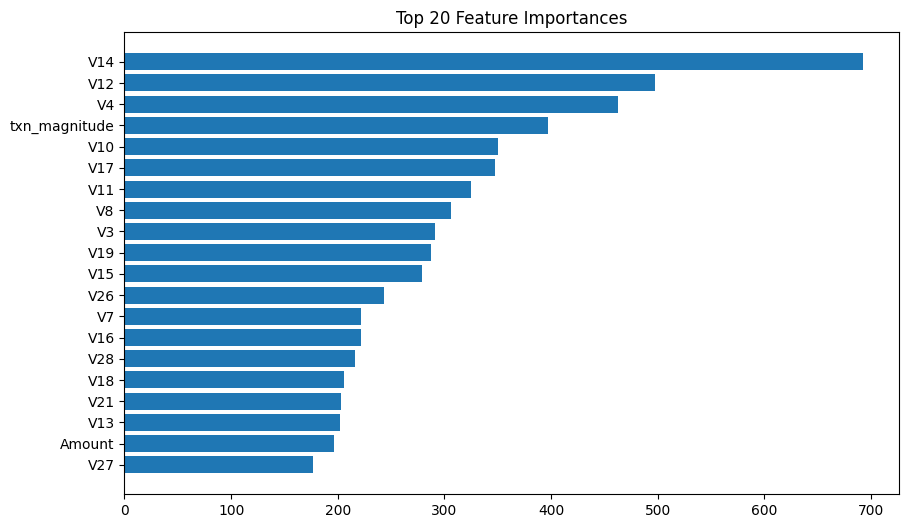

In [0]:
import matplotlib.pyplot as plt
import pandas as pd

importance = model.feature_importances_
feat_df = pd.DataFrame({
    "feature": feature_cols,
    "importance": importance
}).sort_values(by="importance", ascending=False)

plt.figure(figsize=(10,6))
plt.barh(feat_df["feature"][:20], feat_df["importance"][:20])
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importances")
plt.show()


Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


/local_disk0/.ephemeral_nfs/envs/pythonEnv-d92e7d6d-7030-4be0-a0a1-9658da672be0/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


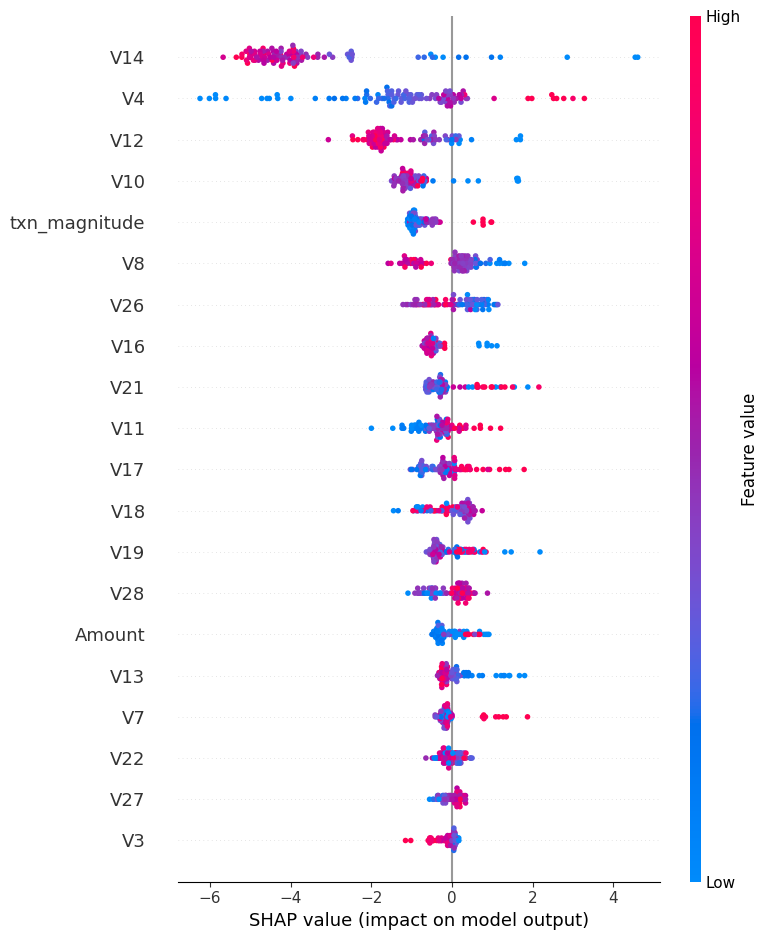

In [0]:
!pip install shap --quiet
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test[:100])

shap.summary_plot(shap_values, X_test[:100], feature_names=feature_cols)


In [0]:
import joblib
joblib.dump(model, "fraud_model_gradboost_lightgbm.pkl")
print("Model saved at fraud_model_gradboost_lightgbm.pkl")


Model saved at fraud_model_gradboost_lightgbm.pkl


In [0]:
import optuna
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 800),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.2, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 16, 256),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
        "random_state": 42,
        "n_jobs": -1,
        "objective": "binary",
        "verbosity": -1,
    }

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    aucs = []
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]

        model = lgb.LGBMClassifier(**params)
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
            callbacks=[lgb.early_stopping(50), lgb.log_evaluation(-1)]
        )
        prob = model.predict_proba(X_val)[:, 1]
        aucs.append(roc_auc_score(y_val, prob))

    return sum(aucs) / len(aucs)

# Create and run the study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=40)

print("Best AUC:", study.best_value)
print("Best params:", study.best_params)


[I 2025-08-30 11:37:13,432] A new study created in memory with name: no-name-a2b5f848-0fc3-4d22-b3ad-3dab38898e5f


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[85]	valid_0's binary_logloss: 0.199991
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[105]	valid_0's binary_logloss: 0.187962
Training until validation scores don't improve for 50 rounds


[I 2025-08-30 11:37:15,686] Trial 0 finished with value: 0.973255661327452 and parameters: {'n_estimators': 196, 'learning_rate': 0.03848330636602695, 'num_leaves': 227, 'max_depth': 11, 'min_child_samples': 5, 'subsample': 0.6359291879603652, 'colsample_bytree': 0.8271129985289583, 'reg_alpha': 1.1073072198858385e-06, 'reg_lambda': 4.738015006205115e-05}. Best is trial 0 with value: 0.973255661327452.


Early stopping, best iteration is:
[105]	valid_0's binary_logloss: 0.183264
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.185946
Training until validation scores don't improve for 50 rounds


[I 2025-08-30 11:37:16,152] Trial 1 finished with value: 0.9749883603825683 and parameters: {'n_estimators': 533, 'learning_rate': 0.15247854220035, 'num_leaves': 200, 'max_depth': 10, 'min_child_samples': 75, 'subsample': 0.8819377510060373, 'colsample_bytree': 0.7361290598931092, 'reg_alpha': 1.3179928347441467, 'reg_lambda': 9.209135460630757e-08}. Best is trial 1 with value: 0.9749883603825683.


Early stopping, best iteration is:
[57]	valid_0's binary_logloss: 0.171329
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[89]	valid_0's binary_logloss: 0.142234
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[135]	valid_0's binary_logloss: 0.195293
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[140]	valid_0's binary_logloss: 0.172602
Training until validation scores don't improve for 50 rounds


[I 2025-08-30 11:37:18,005] Trial 2 finished with value: 0.9751821578055481 and parameters: {'n_estimators': 323, 'learning_rate': 0.030077323217647202, 'num_leaves': 65, 'max_depth': 11, 'min_child_samples': 37, 'subsample': 0.5325114860196722, 'colsample_bytree': 0.7932243399240859, 'reg_alpha': 0.0002712454756788598, 'reg_lambda': 2.0162841836588527e-06}. Best is trial 2 with value: 0.9751821578055481.


Early stopping, best iteration is:
[200]	valid_0's binary_logloss: 0.145853
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[250]	valid_0's binary_logloss: 0.192347
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[257]	valid_0's binary_logloss: 0.170204
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[289]	valid_0's binary_logloss: 0.147969


[I 2025-08-30 11:37:18,619] Trial 3 finished with value: 0.9735573201863046 and parameters: {'n_estimators': 562, 'learning_rate': 0.019788995275113373, 'num_leaves': 220, 'max_depth': 11, 'min_child_samples': 49, 'subsample': 0.6446481821710532, 'colsample_bytree': 0.6493627860539375, 'reg_alpha': 0.5241349855057728, 'reg_lambda': 8.428132916391254e-08}. Best is trial 2 with value: 0.9751821578055481.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[309]	valid_0's binary_logloss: 0.209944
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[309]	valid_0's binary_logloss: 0.193246


[I 2025-08-30 11:37:19,060] Trial 4 finished with value: 0.972310659770598 and parameters: {'n_estimators': 309, 'learning_rate': 0.009133866122870494, 'num_leaves': 64, 'max_depth': 5, 'min_child_samples': 56, 'subsample': 0.8491935090838272, 'colsample_bytree': 0.4753055237469671, 'reg_alpha': 4.326687008154529e-05, 'reg_lambda': 6.470404731786539e-07}. Best is trial 2 with value: 0.9751821578055481.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[309]	valid_0's binary_logloss: 0.185064
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[454]	valid_0's binary_logloss: 0.486721
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[454]	valid_0's binary_logloss: 0.482049
Training until validation scores don't improve for 50 rounds


[I 2025-08-30 11:37:19,676] Trial 5 finished with value: 0.9620679435812587 and parameters: {'n_estimators': 454, 'learning_rate': 0.00100237416335504, 'num_leaves': 45, 'max_depth': 3, 'min_child_samples': 91, 'subsample': 0.6213088385962717, 'colsample_bytree': 0.48991580247798033, 'reg_alpha': 4.2777839010816464e-07, 'reg_lambda': 4.745655569538998}. Best is trial 2 with value: 0.9751821578055481.


Did not meet early stopping. Best iteration is:
[454]	valid_0's binary_logloss: 0.482461
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[358]	valid_0's binary_logloss: 0.194436
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[358]	valid_0's binary_logloss: 0.179247
Training until validation scores don't improve for 50 rounds


[I 2025-08-30 11:37:20,034] Trial 6 finished with value: 0.9730826121479348 and parameters: {'n_estimators': 358, 'learning_rate': 0.01092188806669918, 'num_leaves': 183, 'max_depth': 5, 'min_child_samples': 89, 'subsample': 0.726723220944232, 'colsample_bytree': 0.40418575198424705, 'reg_alpha': 5.6332017895264e-06, 'reg_lambda': 0.0004329891174533868}. Best is trial 2 with value: 0.9751821578055481.


Did not meet early stopping. Best iteration is:
[358]	valid_0's binary_logloss: 0.171795
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[566]	valid_0's binary_logloss: 0.263014
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[566]	valid_0's binary_logloss: 0.25185
Training until validation scores don't improve for 50 rounds


[I 2025-08-30 11:37:27,876] Trial 7 finished with value: 0.9685434556508503 and parameters: {'n_estimators': 566, 'learning_rate': 0.002810407440480014, 'num_leaves': 34, 'max_depth': 10, 'min_child_samples': 39, 'subsample': 0.7708189494489219, 'colsample_bytree': 0.9262774765263079, 'reg_alpha': 0.008430559870727753, 'reg_lambda': 2.0343319493258216e-08}. Best is trial 2 with value: 0.9751821578055481.


Did not meet early stopping. Best iteration is:
[566]	valid_0's binary_logloss: 0.245469
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	valid_0's binary_logloss: 0.189218
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[270]	valid_0's binary_logloss: 0.18388


[I 2025-08-30 11:37:28,238] Trial 8 finished with value: 0.9744327194796282 and parameters: {'n_estimators': 367, 'learning_rate': 0.13449252204218465, 'num_leaves': 157, 'max_depth': 10, 'min_child_samples': 25, 'subsample': 0.7233232378227934, 'colsample_bytree': 0.5791611042143252, 'reg_alpha': 7.068702614075475, 'reg_lambda': 1.0251359127575371e-06}. Best is trial 2 with value: 0.9751821578055481.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[218]	valid_0's binary_logloss: 0.177307
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[192]	valid_0's binary_logloss: 0.231769
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[192]	valid_0's binary_logloss: 0.219185
Training until validation scores don't improve for 50 rounds


[I 2025-08-30 11:37:29,637] Trial 9 finished with value: 0.9706315971320923 and parameters: {'n_estimators': 192, 'learning_rate': 0.014363232208525931, 'num_leaves': 62, 'max_depth': 5, 'min_child_samples': 99, 'subsample': 0.5369581295797249, 'colsample_bytree': 0.6424064321168377, 'reg_alpha': 4.189757145367175, 'reg_lambda': 0.6772006049796465}. Best is trial 2 with value: 0.9751821578055481.


Did not meet early stopping. Best iteration is:
[192]	valid_0's binary_logloss: 0.213952
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[63]	valid_0's binary_logloss: 0.212879
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[78]	valid_0's binary_logloss: 0.179169
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[90]	valid_0's binary_logloss: 0.159008


[I 2025-08-30 11:37:30,391] Trial 10 finished with value: 0.9725129919320233 and parameters: {'n_estimators': 708, 'learning_rate': 0.05009436922337277, 'num_leaves': 113, 'max_depth': 8, 'min_child_samples': 15, 'subsample': 0.9721208950029506, 'colsample_bytree': 0.9471942868690018, 'reg_alpha': 1.9830304046952774e-08, 'reg_lambda': 0.0026472174093412847}. Best is trial 2 with value: 0.9751821578055481.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.1922
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[40]	valid_0's binary_logloss: 0.172975
Training until validation scores don't improve for 50 rounds


[I 2025-08-30 11:37:30,644] Trial 11 finished with value: 0.9741675539851636 and parameters: {'n_estimators': 792, 'learning_rate': 0.17124077350237638, 'num_leaves': 113, 'max_depth': 12, 'min_child_samples': 71, 'subsample': 0.8999791561896163, 'colsample_bytree': 0.7773844075466076, 'reg_alpha': 0.0020463176238125096, 'reg_lambda': 1.105244951061287e-05}. Best is trial 2 with value: 0.9751821578055481.


Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.153334
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	valid_0's binary_logloss: 0.189736
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[78]	valid_0's binary_logloss: 0.169252
Training until validation scores don't improve for 50 rounds


[I 2025-08-30 11:37:30,906] Trial 12 finished with value: 0.974465386926782 and parameters: {'n_estimators': 543, 'learning_rate': 0.07303047660093627, 'num_leaves': 184, 'max_depth': 8, 'min_child_samples': 67, 'subsample': 0.501240002789326, 'colsample_bytree': 0.780062941156461, 'reg_alpha': 0.011292564913439976, 'reg_lambda': 1.0829070141785406e-08}. Best is trial 2 with value: 0.9751821578055481.


Early stopping, best iteration is:
[119]	valid_0's binary_logloss: 0.148181
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.201131
Training until validation scores don't improve for 50 rounds


[I 2025-08-30 11:37:31,925] Trial 13 finished with value: 0.9734919852919969 and parameters: {'n_estimators': 454, 'learning_rate': 0.08670792650659033, 'num_leaves': 256, 'max_depth': 9, 'min_child_samples': 34, 'subsample': 0.8463120272682225, 'colsample_bytree': 0.8556198326321041, 'reg_alpha': 0.0002705531543009377, 'reg_lambda': 1.3827148855286494e-06}. Best is trial 2 with value: 0.9751821578055481.


Early stopping, best iteration is:
[55]	valid_0's binary_logloss: 0.175186
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	valid_0's binary_logloss: 0.156142
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[171]	valid_0's binary_logloss: 0.19175
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[232]	valid_0's binary_logloss: 0.171282
Training until validation scores don't improve for 50 rounds


[I 2025-08-30 11:37:32,864] Trial 14 finished with value: 0.972101852980007 and parameters: {'n_estimators': 279, 'learning_rate': 0.02809338006508185, 'num_leaves': 96, 'max_depth': 12, 'min_child_samples': 75, 'subsample': 0.9902277828554341, 'colsample_bytree': 0.7128984771726216, 'reg_alpha': 0.09178889553773319, 'reg_lambda': 0.009672170830021962}. Best is trial 2 with value: 0.9751821578055481.


Early stopping, best iteration is:
[207]	valid_0's binary_logloss: 0.154255
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[111]	valid_0's binary_logloss: 0.420845
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[111]	valid_0's binary_logloss: 0.41573
Training until validation scores don't improve for 50 rounds


[I 2025-08-30 11:37:33,458] Trial 15 finished with value: 0.9614946445987761 and parameters: {'n_estimators': 111, 'learning_rate': 0.005448516388803143, 'num_leaves': 148, 'max_depth': 7, 'min_child_samples': 57, 'subsample': 0.8035022836725707, 'colsample_bytree': 0.7275395829484883, 'reg_alpha': 0.0002047175829375111, 'reg_lambda': 8.232596895473766e-06}. Best is trial 2 with value: 0.9751821578055481.


Did not meet early stopping. Best iteration is:
[111]	valid_0's binary_logloss: 0.416285
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[23]	valid_0's binary_logloss: 0.198539
Training until validation scores don't improve for 50 rounds


[I 2025-08-30 11:37:34,873] Trial 16 finished with value: 0.9753319571803343 and parameters: {'n_estimators': 646, 'learning_rate': 0.1956172781454591, 'num_leaves': 82, 'max_depth': 10, 'min_child_samples': 44, 'subsample': 0.9147449110561263, 'colsample_bytree': 0.8713868751661059, 'reg_alpha': 0.1390346800873488, 'reg_lambda': 2.4537445743426246e-07}. Best is trial 16 with value: 0.9753319571803343.


Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.169182
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[43]	valid_0's binary_logloss: 0.143187
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[708]	valid_0's binary_logloss: 0.204842
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[708]	valid_0's binary_logloss: 0.181816
Training until validation scores don't improve for 50 rounds


[I 2025-08-30 11:37:38,895] Trial 17 finished with value: 0.9726661757720554 and parameters: {'n_estimators': 708, 'learning_rate': 0.004545975562296422, 'num_leaves': 19, 'max_depth': 7, 'min_child_samples': 41, 'subsample': 0.5653399325526618, 'colsample_bytree': 0.8856038713553991, 'reg_alpha': 0.09099156921238946, 'reg_lambda': 6.359287037405212e-05}. Best is trial 16 with value: 0.9753319571803343.


Did not meet early stopping. Best iteration is:
[708]	valid_0's binary_logloss: 0.168019
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[58]	valid_0's binary_logloss: 0.201933
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	valid_0's binary_logloss: 0.172716
Training until validation scores don't improve for 50 rounds


[I 2025-08-30 11:37:39,510] Trial 18 finished with value: 0.9755785816912791 and parameters: {'n_estimators': 653, 'learning_rate': 0.06707481938372896, 'num_leaves': 87, 'max_depth': 9, 'min_child_samples': 27, 'subsample': 0.7003442595535947, 'colsample_bytree': 0.9517855288911515, 'reg_alpha': 2.4376790873474398e-05, 'reg_lambda': 2.490379474401587e-07}. Best is trial 18 with value: 0.9755785816912791.


Early stopping, best iteration is:
[83]	valid_0's binary_logloss: 0.149236
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[40]	valid_0's binary_logloss: 0.205464
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[52]	valid_0's binary_logloss: 0.171604
Training until validation scores don't improve for 50 rounds


[I 2025-08-30 11:37:39,946] Trial 19 finished with value: 0.9740168717064003 and parameters: {'n_estimators': 648, 'learning_rate': 0.07765348993860112, 'num_leaves': 89, 'max_depth': 9, 'min_child_samples': 22, 'subsample': 0.6953806580236943, 'colsample_bytree': 0.9994455151736764, 'reg_alpha': 2.0869210945215078e-05, 'reg_lambda': 0.07033021476461171}. Best is trial 18 with value: 0.9755785816912791.


Early stopping, best iteration is:
[61]	valid_0's binary_logloss: 0.154048
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.216426
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[22]	valid_0's binary_logloss: 0.197565
Training until validation scores don't improve for 50 rounds


[I 2025-08-30 11:37:40,663] Trial 20 finished with value: 0.971458951733994 and parameters: {'n_estimators': 789, 'learning_rate': 0.19403602607222137, 'num_leaves': 123, 'max_depth': 6, 'min_child_samples': 9, 'subsample': 0.9327311840441035, 'colsample_bytree': 0.9977707480120142, 'reg_alpha': 1.2417352440456379e-08, 'reg_lambda': 1.5344822162151746e-07}. Best is trial 18 with value: 0.9755785816912791.


Early stopping, best iteration is:
[27]	valid_0's binary_logloss: 0.175013
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[108]	valid_0's binary_logloss: 0.197651
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[120]	valid_0's binary_logloss: 0.169341
Training until validation scores don't improve for 50 rounds


[I 2025-08-30 11:37:41,613] Trial 21 finished with value: 0.9746141562469282 and parameters: {'n_estimators': 643, 'learning_rate': 0.04040103539042966, 'num_leaves': 77, 'max_depth': 9, 'min_child_samples': 29, 'subsample': 0.5881764637881445, 'colsample_bytree': 0.9156496258932517, 'reg_alpha': 0.001877601316330064, 'reg_lambda': 2.337720559884515e-06}. Best is trial 18 with value: 0.9755785816912791.


Early stopping, best iteration is:
[133]	valid_0's binary_logloss: 0.149232
Training until validation scores don't improve for 50 rounds


[I 2025-08-30 11:37:41,986] Trial 22 finished with value: 0.9740142229944689 and parameters: {'n_estimators': 626, 'learning_rate': 0.10589473235382181, 'num_leaves': 51, 'max_depth': 11, 'min_child_samples': 45, 'subsample': 0.7928893437281818, 'colsample_bytree': 0.8093297206329496, 'reg_alpha': 2.9879631363757638e-05, 'reg_lambda': 2.5692694273003883e-07}. Best is trial 18 with value: 0.9755785816912791.


Early stopping, best iteration is:
[44]	valid_0's binary_logloss: 0.195421
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[51]	valid_0's binary_logloss: 0.171565
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[58]	valid_0's binary_logloss: 0.150032
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[59]	valid_0's binary_logloss: 0.202565
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	valid_0's binary_logloss: 0.17761
Training until validation scores don't improve for 50 rounds


[I 2025-08-30 11:37:42,870] Trial 23 finished with value: 0.9742886589806932 and parameters: {'n_estimators': 725, 'learning_rate': 0.06411668588813703, 'num_leaves': 84, 'max_depth': 10, 'min_child_samples': 18, 'subsample': 0.6831149131171814, 'colsample_bytree': 0.8559943264595028, 'reg_alpha': 0.001194189502145227, 'reg_lambda': 4.4362836582676014e-06}. Best is trial 18 with value: 0.9755785816912791.


Early stopping, best iteration is:
[81]	valid_0's binary_logloss: 0.149778
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[171]	valid_0's binary_logloss: 0.201733
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[164]	valid_0's binary_logloss: 0.174756
Training until validation scores don't improve for 50 rounds


[I 2025-08-30 11:37:43,784] Trial 24 finished with value: 0.9739780239314065 and parameters: {'n_estimators': 473, 'learning_rate': 0.024942060416941022, 'num_leaves': 100, 'max_depth': 12, 'min_child_samples': 32, 'subsample': 0.8346249650200857, 'colsample_bytree': 0.8864889338632993, 'reg_alpha': 1.9006753626267892e-06, 'reg_lambda': 2.593566654643416e-05}. Best is trial 18 with value: 0.9755785816912791.


Early stopping, best iteration is:
[224]	valid_0's binary_logloss: 0.151186
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[32]	valid_0's binary_logloss: 0.206097
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.17316
Training until validation scores don't improve for 50 rounds


[I 2025-08-30 11:37:44,547] Trial 25 finished with value: 0.9748765258787984 and parameters: {'n_estimators': 373, 'learning_rate': 0.1175134719036807, 'num_leaves': 129, 'max_depth': 9, 'min_child_samples': 37, 'subsample': 0.6699989374598909, 'colsample_bytree': 0.9548979015741906, 'reg_alpha': 0.030944032876949554, 'reg_lambda': 0.00025686380687880105}. Best is trial 18 with value: 0.9755785816912791.


Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.142564
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[80]	valid_0's binary_logloss: 0.194783
Training until validation scores don't improve for 50 rounds


[I 2025-08-30 11:37:44,941] Trial 26 finished with value: 0.9734446027785576 and parameters: {'n_estimators': 259, 'learning_rate': 0.05488493655376215, 'num_leaves': 16, 'max_depth': 11, 'min_child_samples': 62, 'subsample': 0.6016605296380113, 'colsample_bytree': 0.7753321661955789, 'reg_alpha': 0.00020611689073116968, 'reg_lambda': 2.9276622127222545e-08}. Best is trial 18 with value: 0.9755785816912791.


Early stopping, best iteration is:
[126]	valid_0's binary_logloss: 0.174164
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[126]	valid_0's binary_logloss: 0.144628
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[126]	valid_0's binary_logloss: 0.196403
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[143]	valid_0's binary_logloss: 0.170184
Training until validation scores don't improve for 50 rounds


[I 2025-08-30 11:37:46,068] Trial 27 finished with value: 0.9741016304882048 and parameters: {'n_estimators': 495, 'learning_rate': 0.032752904648282455, 'num_leaves': 67, 'max_depth': 8, 'min_child_samples': 49, 'subsample': 0.5091103188975072, 'colsample_bytree': 0.8418694210893318, 'reg_alpha': 8.401662120519052e-06, 'reg_lambda': 3.534558859183631e-07}. Best is trial 18 with value: 0.9755785816912791.


Early stopping, best iteration is:
[173]	valid_0's binary_logloss: 0.142322
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[240]	valid_0's binary_logloss: 0.194438
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[271]	valid_0's binary_logloss: 0.169138
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[327]	valid_0's binary_logloss: 0.148767


[I 2025-08-30 11:37:47,934] Trial 28 finished with value: 0.9745630949669176 and parameters: {'n_estimators': 416, 'learning_rate': 0.017435527177463935, 'num_leaves': 38, 'max_depth': 10, 'min_child_samples': 43, 'subsample': 0.9539018717058502, 'colsample_bytree': 0.6621139180867527, 'reg_alpha': 6.221477222959091e-08, 'reg_lambda': 2.2897755587969866e-06}. Best is trial 18 with value: 0.9755785816912791.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[83]	valid_0's binary_logloss: 0.197274
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[88]	valid_0's binary_logloss: 0.187289
Training until validation scores don't improve for 50 rounds


[I 2025-08-30 11:37:49,173] Trial 29 finished with value: 0.9728532042645438 and parameters: {'n_estimators': 189, 'learning_rate': 0.04246708739913848, 'num_leaves': 143, 'max_depth': 11, 'min_child_samples': 8, 'subsample': 0.7539724668819761, 'colsample_bytree': 0.8209882188819934, 'reg_alpha': 5.445750985281916e-07, 'reg_lambda': 8.161806149013066e-05}. Best is trial 18 with value: 0.9755785816912791.


Early stopping, best iteration is:
[92]	valid_0's binary_logloss: 0.171484
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.196722
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[40]	valid_0's binary_logloss: 0.173844
Training until validation scores don't improve for 50 rounds


[I 2025-08-30 11:37:49,778] Trial 30 finished with value: 0.9751530219743029 and parameters: {'n_estimators': 624, 'learning_rate': 0.10039779000654486, 'num_leaves': 106, 'max_depth': 11, 'min_child_samples': 25, 'subsample': 0.5564572414763803, 'colsample_bytree': 0.8931230487280706, 'reg_alpha': 9.009879203621614e-05, 'reg_lambda': 3.3173784263211684e-08}. Best is trial 18 with value: 0.9755785816912791.


Early stopping, best iteration is:
[54]	valid_0's binary_logloss: 0.150822
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.201053
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[41]	valid_0's binary_logloss: 0.172922
Training until validation scores don't improve for 50 rounds


[I 2025-08-30 11:37:50,217] Trial 31 finished with value: 0.9745775157318773 and parameters: {'n_estimators': 661, 'learning_rate': 0.10178298493106688, 'num_leaves': 108, 'max_depth': 11, 'min_child_samples': 26, 'subsample': 0.5540756945566675, 'colsample_bytree': 0.8948510198539084, 'reg_alpha': 6.82084215772716e-05, 'reg_lambda': 5.1781352504509505e-08}. Best is trial 18 with value: 0.9755785816912791.


Early stopping, best iteration is:
[40]	valid_0's binary_logloss: 0.150805
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[23]	valid_0's binary_logloss: 0.199592
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.163897
Training until validation scores don't improve for 50 rounds


[I 2025-08-30 11:37:51,451] Trial 32 finished with value: 0.9766151109604287 and parameters: {'n_estimators': 583, 'learning_rate': 0.13128119456556495, 'num_leaves': 77, 'max_depth': 12, 'min_child_samples': 20, 'subsample': 0.6522935626675963, 'colsample_bytree': 0.9486101030134573, 'reg_alpha': 0.0006047096590982023, 'reg_lambda': 2.5323201438523244e-07}. Best is trial 32 with value: 0.9766151109604287.


Early stopping, best iteration is:
[44]	valid_0's binary_logloss: 0.147501
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[31]	valid_0's binary_logloss: 0.204553
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.171409


[I 2025-08-30 11:37:51,688] Trial 33 finished with value: 0.9747357026944464 and parameters: {'n_estimators': 575, 'learning_rate': 0.155809588201787, 'num_leaves': 78, 'max_depth': 12, 'min_child_samples': 15, 'subsample': 0.6416305073077192, 'colsample_bytree': 0.9593622365865843, 'reg_alpha': 1.0888146016488183, 'reg_lambda': 2.876861918172934e-07}. Best is trial 32 with value: 0.9766151109604287.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[40]	valid_0's binary_logloss: 0.158671
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[100]	valid_0's binary_logloss: 0.191418
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[88]	valid_0's binary_logloss: 0.172423
Training until validation scores don't improve for 50 rounds


[I 2025-08-30 11:37:52,136] Trial 34 finished with value: 0.973976699575441 and parameters: {'n_estimators': 512, 'learning_rate': 0.054784832874250525, 'num_leaves': 60, 'max_depth': 12, 'min_child_samples': 50, 'subsample': 0.7104693994321559, 'colsample_bytree': 0.9723256183976563, 'reg_alpha': 0.0008116344634265099, 'reg_lambda': 1.3769730133577405e-07}. Best is trial 32 with value: 0.9766151109604287.


Early stopping, best iteration is:
[97]	valid_0's binary_logloss: 0.154485
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.205167
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.172027
Training until validation scores don't improve for 50 rounds


[I 2025-08-30 11:37:52,631] Trial 35 finished with value: 0.9741600493013581 and parameters: {'n_estimators': 590, 'learning_rate': 0.1393381426067291, 'num_leaves': 77, 'max_depth': 10, 'min_child_samples': 32, 'subsample': 0.6604030473872624, 'colsample_bytree': 0.9197386783391648, 'reg_alpha': 0.004102234871288036, 'reg_lambda': 9.287902946829037e-07}. Best is trial 32 with value: 0.9766151109604287.


Early stopping, best iteration is:
[45]	valid_0's binary_logloss: 0.146502
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[213]	valid_0's binary_logloss: 0.198591
Training until validation scores don't improve for 50 rounds


[I 2025-08-30 11:37:53,453] Trial 36 finished with value: 0.9749911562451624 and parameters: {'n_estimators': 756, 'learning_rate': 0.022082174807759463, 'num_leaves': 49, 'max_depth': 3, 'min_child_samples': 17, 'subsample': 0.6154373411036955, 'colsample_bytree': 0.7924389784055812, 'reg_alpha': 0.3882497406318032, 'reg_lambda': 1.4932022157081854e-05}. Best is trial 32 with value: 0.9766151109604287.


Early stopping, best iteration is:
[201]	valid_0's binary_logloss: 0.169342
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[276]	valid_0's binary_logloss: 0.14941
Training until validation scores don't improve for 50 rounds


[I 2025-08-30 11:37:53,612] Trial 37 finished with value: 0.972101852980007 and parameters: {'n_estimators': 675, 'learning_rate': 0.19466003221446262, 'num_leaves': 67, 'max_depth': 9, 'min_child_samples': 55, 'subsample': 0.8893936109704446, 'colsample_bytree': 0.7490241188044564, 'reg_alpha': 6.229152803659753e-06, 'reg_lambda': 7.669464116164632e-08}. Best is trial 32 with value: 0.9766151109604287.


Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.200103
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.17207
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.154607
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[123]	valid_0's binary_logloss: 0.200491
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[121]	valid_0's binary_logloss: 0.17244
Training until validation scores don't improve for 50 rounds


[I 2025-08-30 11:37:54,600] Trial 38 finished with value: 0.9739413834163556 and parameters: {'n_estimators': 600, 'learning_rate': 0.035251208624264244, 'num_leaves': 35, 'max_depth': 11, 'min_child_samples': 36, 'subsample': 0.7462640576946585, 'colsample_bytree': 0.8587405477042017, 'reg_alpha': 1.5255398043224455e-07, 'reg_lambda': 6.374683745217957e-07}. Best is trial 32 with value: 0.9766151109604287.


Early stopping, best iteration is:
[155]	valid_0's binary_logloss: 0.148111
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[323]	valid_0's binary_logloss: 0.461914
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[323]	valid_0's binary_logloss: 0.458707
Training until validation scores don't improve for 50 rounds


[I 2025-08-30 11:37:55,958] Trial 39 finished with value: 0.9609398865998132 and parameters: {'n_estimators': 323, 'learning_rate': 0.0014364124693126766, 'num_leaves': 94, 'max_depth': 10, 'min_child_samples': 45, 'subsample': 0.6331515825417098, 'colsample_bytree': 0.9262762620788215, 'reg_alpha': 0.0005645648892196708, 'reg_lambda': 4.346220906086369e-06}. Best is trial 32 with value: 0.9766151109604287.


Did not meet early stopping. Best iteration is:
[323]	valid_0's binary_logloss: 0.45665
Best AUC: 0.9766151109604287
Best params: {'n_estimators': 583, 'learning_rate': 0.13128119456556495, 'num_leaves': 77, 'max_depth': 12, 'min_child_samples': 20, 'subsample': 0.6522935626675963, 'colsample_bytree': 0.9486101030134573, 'reg_alpha': 0.0006047096590982023, 'reg_lambda': 2.5323201438523244e-07}


In [0]:
best_params = study.best_params
final_model = lgb.LGBMClassifier(**best_params, n_jobs=-1, random_state=42)
final_model.fit(X_train, y_train)


LGBMClassifier(colsample_bytree=0.9486101030134573,
               learning_rate=0.13128119456556495, max_depth=12,
               n_estimators=583, n_jobs=-1, num_leaves=77, random_state=42,
               reg_alpha=0.0006047096590982023,
               reg_lambda=2.5323201438523244e-07, subsample=0.6522935626675963)

In [0]:
from sklearn.metrics import roc_auc_score
y_prob = final_model.predict_proba(X_test)[:, 1]
print("Test AUC:", roc_auc_score(y_test, y_prob))


Test AUC: 0.9842300556586271


In [0]:
import json

with open("feature_list.json", "w") as f:
    json.dump(feature_cols, f)

print("✅ Feature list saved as feature_list.json")


✅ Feature list saved as feature_list.json


In [0]:
#dbutils.library.restartPython()


In [0]:
with open("feature_list.json") as f:
    features = json.load(f)
print("Feature count:", len(features))
print("First few:", features[:5])


Feature count: 32
First few: ['V1', 'V2', 'V3', 'V4', 'V5']


In [0]:
import joblib
import pandas as pd
import json

# Load model
model = joblib.load("fraud_model_gradboost_lightgbm.pkl")

# Load feature order
with open("feature_list.json") as f:
    feature_cols = json.load(f)

def predict_transaction(features):
    """
    features: list of numeric values in the same order as feature_cols
    """
    df = pd.DataFrame([features], columns=feature_cols)
    prob = model.predict_proba(df)[0][1]
    pred = int(prob >= 0.5)
    return {"fraud_probability": float(prob), "prediction": pred}


In [0]:
sample_input = [0.2 for _ in range(len(feature_cols))]  # Dummy input
print(predict_transaction(sample_input))


{'fraud_probability': 0.006749602080437404, 'prediction': 0}
